# Gil Data Exploration for Milestone 3

In [181]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division

In [42]:
# food inspection database
data_FI = pd.read_csv('datasets/Food_Inspections.csv')

Let us have a quick look at the data.

In [43]:
data_FI.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1967170,"GOOSE ISLAND BAR - T1, B4",GOOSE ISLAND (T1-B4),2477070.0,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,CHICAGO,IL,60666.0,10/25/2016,License,Pass,NaN,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
1,1967164,ERMEL'S,ERMEL'S,2484238.0,Restaurant,Risk 1 (High),5729 N NORTHWEST HWY,CHICAGO,IL,60646.0,10/25/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.986001,-87.787528,"(41.98600113711187, -87.78752792018707)"
2,1967146,"WENDY'S PROPERTIES, LLC",WENDY'S,2469194.0,Restaurant,Risk 1 (High),6324 N WESTERN AVE,CHICAGO,IL,60659.0,10/25/2016,License,Pass,NaN,41.996677,-87.689996,"(41.99667685737697, -87.68999575516291)"
3,1967133,LEARN TOGETHER GROW TOGETHER CHILD DEVELOPMENT...,LEARN TOGETHER GROW TOGETHER CHILD DEVELOPMENT C,2384887.0,Daycare Above and Under 2 Years,Risk 1 (High),1126 W 99TH ST,CHICAGO,IL,60643.0,10/25/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.714241,-87.651464,"(41.714240500986136, -87.6514643961654)"
4,1967115,Porkchop,Porkchop,2373923.0,Restaurant,Risk 1 (High),29 E ADAMS ST,CHICAGO,IL,60603.0,10/24/2016,Short Form Complaint,Pass,NaN,41.879397,-87.626631,"(41.87939700209408, -87.62663087278814)"


## Violations and Risk Level

In this portion of the notebook, we will explore the subtleties and apparent implications of the type and number of violations that a restaurant has. We will also investigate the built-in `Risk` and explor how predictive this baseline really is.

### Data Cleaning

The way that the violiations are structured in the dataset provides a slight problem. Firstly, all violations are stored as a single string. Secondly, most violations have comments associated with them. Because of these complications, parsing of the dataset in its raw form is impossible. We will need to clean the data to convert it into an interpretable form.

In [111]:
# cleaned data. will be inputted into DF after cleaning
viol_list_of_lists = []

for i, viol in enumerate(data_FI.Violations):
    # for each establishment
    viols = []
    
    # if nan, no complaints
    if pd.isnull(viol):
        viol_list_of_lists.append(viols)
    else:
        # split into separate complaints
        viols = viol.split(' | ')
        for j, complaint in enumerate(viols):
            complaint = complaint.split(' - Comments: ')[0]
            viols[j] = complaint
        viol_list_of_lists.append(viols)

Let us have a quick look at the form that our violations now take. We will inspect the first five restaurants.

In [112]:
viol_list_of_lists[:5]

[[],
 ['32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
  '38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED',
  '43. FOOD (ICE) DISPENSING UTENSILS, WASH CLOTHS PROPERLY STORED',
  '33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
  '35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
  '41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED'],
 [],
 ['32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
  '33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
  '34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED'],
 []]

To make life even easier, notice that only the number of the violation is important for data analysis purposes. We can incorporate the meaning of the number later in a more qualitative manner. However, for our purposes, we only need the number of the violations.

We will create a `Dict` to sotr these values for later.

In [113]:
violation_code_dict = {}
for lst in viol_list_of_lists:
    for viol in lst:
        code = int(viol.split('. ')[0])
        viol_ = viol.split('. ')[1]
        violation_code_dict[code] = viol_

# all the unique violations
violation_code_dict

{1: 'SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PROPERLY LABELED, SHELLFISH TAGS IN PLACE',
 2: 'FACILITIES TO MAINTAIN PROPER TEMPERATURE',
 3: 'POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE',
 4: 'SOURCE OF CROSS CONTAMINATION CONTROLLED I.E',
 5: 'PERSONNEL WITH INFECTIONS RESTRICTED: NO OPEN SORES, WOUNDS, ETC',
 6: 'HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACTICES; NO BARE HAND CONTACT WITH READY-TO-EAT FOODS.',
 7: 'WASH AND RINSE WATER: CLEAN AND PROPER TEMPERATURE',
 8: 'SANITIZING RINSE FOR EQUIPMENT AND UTENSILS:  CLEAN, PROPER TEMPERATURE, CONCENTRATION, EXPOSURE TIME',
 9: 'WATER SOURCE: SAFE, HOT & COLD UNDER CITY PRESSURE',
 10: 'SEWAGE AND WASTE WATER DISPOSAL, NO BACK SIPHONAGE, CROSS  CONNECTION AND/OR BACK FLOW',
 11: 'ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED',
 12: 'HAND WASHING FACILITIES: WITH SOAP AND SANITARY HAND DRYING DEVICES, CONVENIENT AND ACCESSIBLE TO FOOD PREP AREA',
 13:

Now that we have this reference `Dict`, let us update our `viol_list_of_lists`.

In [114]:
# update so that viol_list_of_lists only stores numeric values
for lst in viol_list_of_lists:
    for i, viol in enumerate(lst):
        code = viol.split('. ')[0]
        lst[i] = int(code)

viol_list_of_lists[:5]

[[], [32, 38, 43, 33, 35, 41], [], [32, 33, 34], []]

### Analysis and Visualization

Let us have a look at the distribution of number of violations per restaurant.

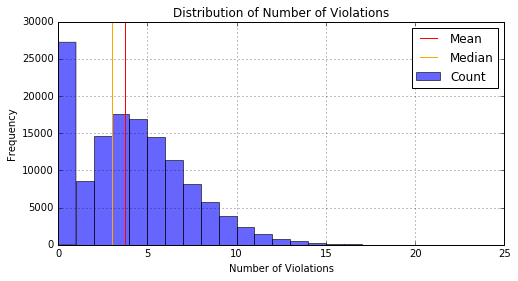

In [120]:
# number of violations per establisment
number_viols = [len(x) for x in viol_list_of_lists]
number_viols_df = pd.Series(data=number_viols, index=data_FI['Inspection ID'], name='Number of Violations')

# visualization
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax = number_viols_df.hist(bins=number_viols_df.max(), alpha=0.6, label='Count')
ax.axvline(number_viols_df.mean(), color='red', label='Mean')
ax.axvline(number_viols_df.median(), color='orange', label='Median')
ax.set_title('Distribution of Number of Violations')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Violations')
ax.legend();

As we can see from the distribution, very many restaurants have 0 violations (it is the mode of the distribution) but the majority of the density is around 2 to 5 violations. This could be modeled by a zero-inflated poisson distribution in order to generate confidence intervals.

Now let's have a look at which violations are the most common.

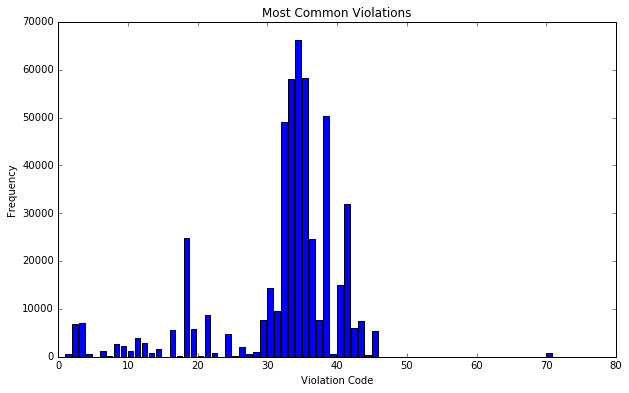

In [116]:
from collections import Counter

# full list of all violations unsorted
violations_ = [item for sublist in viol_list_of_lists for item in sublist]

# count values
counted_violations_dict = Counter(violations_)

# visualization
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots(1, 1)

# each number of violations assigned a bin
ax.bar(
    counted_violations_dict.keys(),
    counted_violations_dict.values()
)
ax.set_title('Most Common Violations')
ax.set_ylabel('Frequency')
ax.set_xlabel('Violation Code');

So what are these most common violations?

In [119]:
for i, tup in enumerate(counted_violations_dict.most_common()[:5]):
    code, _ = tup
    print '{0}: {1}'.format(i + 1, violation_code_dict[code])

1: FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED
2: WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS
3: FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS
4: VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED
5: FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED


Something to note here that is very interesting is that the most common violations seem to be related to the buildings themselves. We will see if there is a source of building code data and hopefully integrate that in order to test that signal's predictive power in our model.

## Temporal Data (Climate, Season, etc.)

In this section we will explore how violations change over time in order to investigate any possible time dependencies in the data structure.

First we will see if there is any seasonal component to the number of inspections carried out.

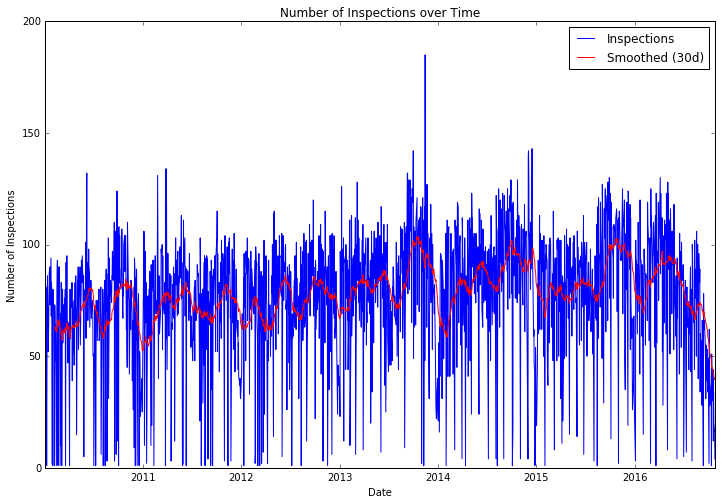

In [316]:
data_FI['Inspection Date'] = pd.to_datetime(data_FI['Inspection Date'], infer_datetime_format=True)
inspections_over_time = data_FI.groupby('Inspection Date').count().loc[:, 'Results']

# smoothed mean
roll = inspections_over_time.rolling(window=30).mean()

# plot results
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(inspections_over_time, label='Inspections')
plt.plot(roll, color='r', label='Smoothed (30d)')
plt.title('Number of Inspections over Time')
plt.xlabel('Date')
plt.ylabel('Number of Inspections')
plt.legend();

As we can see from the graph above, there definitely appears to be a seasonal trend to the data, with peaks and troughs occuring with some degree of regularity. Let us dig into these more by examining the data on a monthly basis.

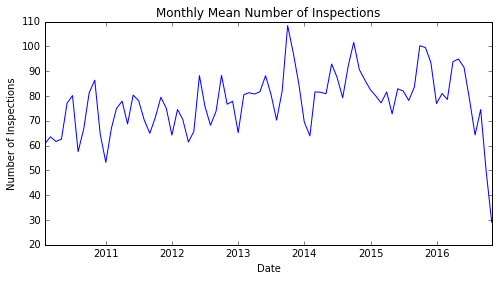

In [317]:
# monthly resample plot
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(inspections_over_time.resample('M').mean())
plt.title('Monthly Mean Number of Inspections')
plt.ylabel('Number of Inspections')
plt.xlabel('Date');

Here, the seasonality is much more apparent. Another feature that comes out of the data is the steep drop off in number of inpections in 2016. I believe that there are two possible causes for this:

* The quantitative approach to inspections has made food inspection more efficient. Therefore fewer inspections need to be conducted.

* Data has not been processed for more recent dates.

I am inclined to believe that the second of these is the case as the decrease in this number is very drastic indeed. One way we could test this more rigorously is to check the proportion of `Fails` over time. If efficiency really has improved so drastically, we would see an uptick in the proportion of `Fails` as resources are only being allocated to at-risk food establishments. We will do this now:

In [318]:
group_by_date = data_FI.groupby('Inspection Date')

# proportion of fails
prop_fails = []

# loop though groupings
for name, group in group_by_date:
    
    # as long as `Fail` exists
    try:
        fail_count = group.groupby('Results').count().loc[:, 'License #'].loc['Fail']
    except KeyError:
        fail_count = 0
        
    tot_count = group.groupby('Results').count().loc[:, 'License #'].sum()
    prop_fails.append(fail_count / tot_count)

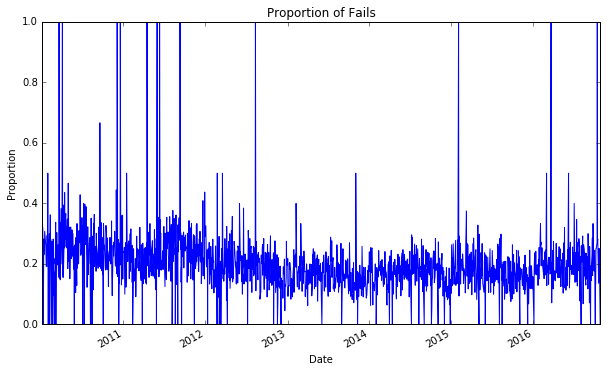

In [319]:
plt.rcParams['figure.figsize'] = (10, 6)
pd.Series(prop_fails, index=inspections_over_time.index).plot()
plt.title('Proportion of Fails')
plt.ylabel('Proportion')
plt.xlabel('Date');

As we can see above, there is no discernable uptick in the proportion of fails. This suggests that the data for 2016 has not been processed yet; therefore, we should remove this data from the fitting of our model as it is not a representative sample of the population.

One transformation that we will use is the fact that there appears to be a little bit of upwards drift in the monthly mean number of inspections. In order to combat this tendency in the model, we will take the first difference of the inspection over time dataset.

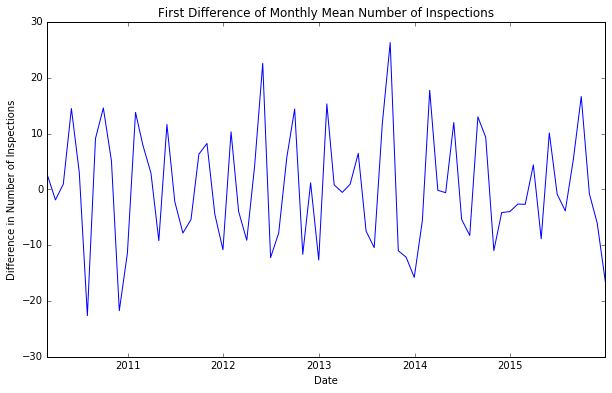

In [320]:
# our transformations of inspections over time
# 1. Truncate to 2016
# 2. Monthly
# 3. 1 lag difference

inspections_over_time= inspections_over_time[inspections_over_time.index < pd.to_datetime('01-01-2016')] \
    .resample('M') \
    .mean()
    
diff_inspections_over_time = inspections_over_time.diff()[1:]

plt.plot(diff_inspections_over_time)
plt.title('First Difference of Monthly Mean Number of Inspections')
plt.ylabel('Difference in Number of Inspections')
plt.xlabel('Date');

Now that we have our time series, let us perform some analysis on the data with a view to fitting an SARIMA model. This is just a normal ARMA model with a differencing term (there appears to be some drift -i.e the process itself is not stationary) and a seasonality component.

We will plot the autocorrelation function and partial autocorrelation function of this data in order to examine intertemporal dependencies.

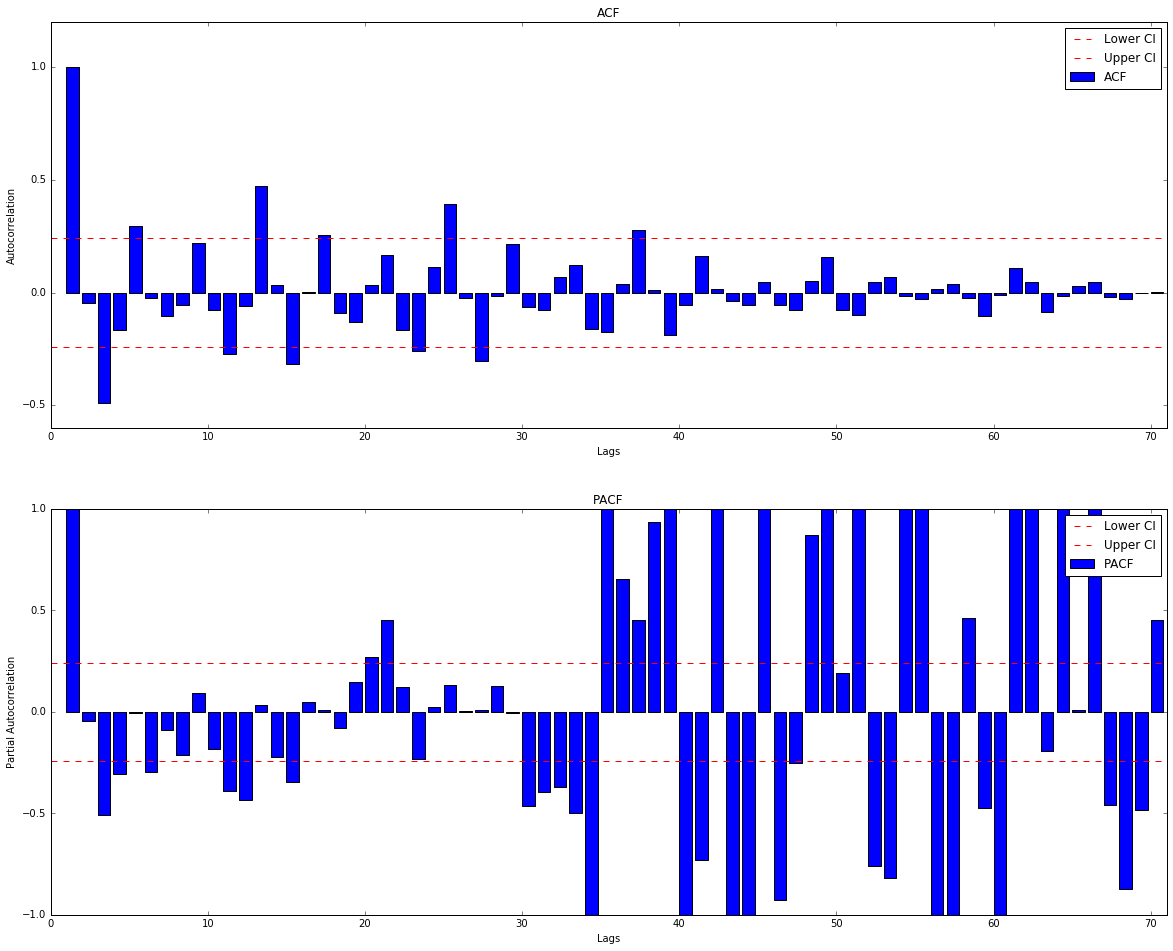

In [321]:
import scipy.stats as stats
import statsmodels.tsa.stattools as stattools

lags = len(diff_inspections_over_time.index)

# white noise process
weak_white_noise_CI = stats.norm.pdf(0.95, loc=0, scale=(np.var(diff_inspections_over_time)/lags)**0.5)

plt.rcParams['figure.figsize'] = (20, 16)
fig, (acf, pacf) = plt.subplots(2, 1)

acf.bar(np.arange(lags) + 1, stattools.acf(diff_inspections_over_time, nlags=lags), label='ACF')
acf.axhline(-weak_white_noise_CI, ls='--', c='r', label='Lower CI')
acf.axhline(weak_white_noise_CI, ls='--', c='r', label='Upper CI')
acf.set_title('ACF')
acf.set_xlabel('Lags')
acf.set_ylabel('Autocorrelation')
acf.set_xlim([0, lags])
acf.legend()

pacf.bar(np.arange(lags) + 1, stattools.pacf(diff_inspections_over_time, nlags=lags)[:-1], label='PACF')
pacf.axhline(-weak_white_noise_CI, ls='--', c='r', label='Lower CI')
pacf.axhline(weak_white_noise_CI, ls='--', c='r', label='Upper CI')
pacf.set_title('PACF')
pacf.set_xlabel('Lags')
pacf.set_ylabel('Partial Autocorrelation')
pacf.set_xlim([0, lags])
pacf.set_ylim([-1, 1])
pacf.legend();

These plots reveal a few interesting facts:

* The ACF function tails off, therefore not an AR model.
* There is a yearly seasonal component to the model (AR bars above white noise band every 6th difference)
* PACF of the first term is very strong (PACF for larger lags is very inaccurate so we will discount this)

Therefore we will try to fit a SARIMA model based on a MA(1) process with a seasonal difference component of 6.

However, there is one slight technical hitch: the SARMIA package in statsmodels is now unavailable in this release, therefore we will fit an ARIMA(6, 1, 1) process. This model is fundamentally flawed as it involves fitting more predictors (6 AR coefficients) as opposed to a single seasonal component for the AR process. The model is therefore more complicated than it should be. 

Let us check the fit of this model.

In [346]:
from statsmodels.tsa.arima_model import ARIMA

arima_model = ARIMA(inspections_over_time.astype('float64'), (6, 1, 1)).fit()

C:\Users\wasse\Anaconda3\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


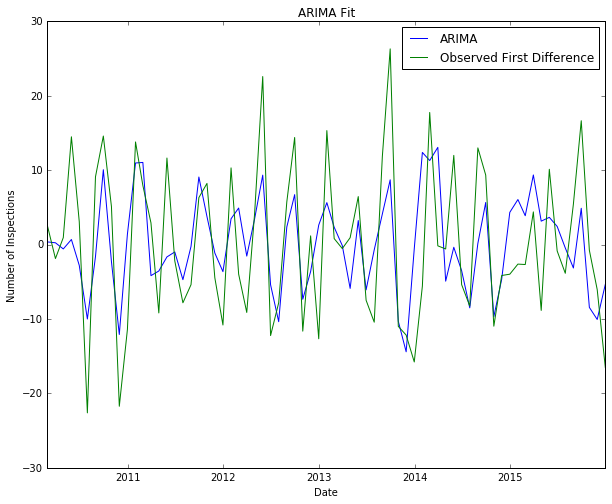

In [347]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(arima_model.predict(), label='ARIMA')
plt.plot(diff_inspections_over_time, label='Observed First Difference')
plt.title('ARIMA Fit')
plt.ylabel('Number of Inspections')
plt.xlabel('Date')
plt.legend();

As we can see above, direction of the ARIMA process appears to be generally correct, but the amplitudes appear to ve a little too extreme. We will check at a later date to see if this temporal component is a useful prediction / forecasting mechanism for the model.